## Modeling / Evaluation /Deployment to WML using Pyspark
<img src="https://github.com/CatherineCao2016/lendingclub/raw/master/modeling.png" width="800" height="500" align="middle"/>


We are trying to predict the likliehood of default given borrowers data.  


## Import Libraries

In [28]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math
import urllib3, requests, json

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict


loan_df = pd.read_pickle("01-dataprep-loan_short_df.pkl")


## Load Cleaned Data

In [29]:
loan_df.head()

,id,addr_state,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,home_ownership,inq_last_6mths,installment,int_rate,issue_d,loan_amnt,loan_status,open_acc,purpose,pymnt_plan,revol_bal,sub_grade,term,total_acc,total_pymnt,verification_status,zip_code,acc_now_delinq,acc_open_past_24mths,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,debt_settlement_flag,delinq_amnt,disbursement_method,earliest_cr_line,initial_list_status,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,mort_acc,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,default,time_history,emp_bin,revol_util_1
0,10159548,FL,63000.0,0.0,0.0,16.51,674.0,670.0,15000.0,15000.0,A,MORTGAGE,0.0,476.30,0.0890,2013-12-01,15000.0,Fully Paid,8.0,debt_consolidation,n,11431.0,A5,36 months,29.0,17146.725104,Not Verified,334xx,0.0,3.0,Individual,38927.0,2969.0,79.1,0.0,0.0,N,0.0,Cash,1998-03-01,w,669.0,665.0,476.23,4.0,0.0,0.0,89.3,66.7,1.0,0.0,0.0,0.0,0.0,39448.0,14200.0,33895.0,17146.73,2146.73,0.0,15000.0,0,5754,0_3yrs,0.432485
1,10127816,MI,100000.0,0.0,0.0,22.18,664.0,660.0,24000.0,24000.0,B,MORTGAGE,0.0,814.80,0.1353,2013-12-01,24000.0,Fully Paid,14.0,credit_card,n,21617.0,B5,36 months,39.0,28652.210000,Verified,493xx,0.0,7.0,Individual,15372.0,4822.0,77.6,0.0,0.0,N,0.0,Cash,1989-01-01,w,699.0,695.0,10726.61,3.0,0.0,0.0,100.0,75.0,1.0,0.0,0.0,0.0,0.0,61397.0,21500.0,58847.0,28652.21,4652.21,0.0,24000.0,0,9100,gt_6yrs,0.473880
2,10139658,NM,40000.0,0.0,0.0,16.94,664.0,660.0,12000.0,12000.0,B,RENT,0.0,407.40,0.1353,2013-12-01,12000.0,Fully Paid,7.0,debt_consolidation,n,5572.0,B5,36 months,32.0,13359.776858,Source Verified,871xx,0.0,4.0,Individual,2268.0,1428.0,79.6,0.0,0.0,N,0.0,Cash,1998-10-01,w,739.0,735.0,119.17,0.0,0.0,0.0,81.2,33.3,1.0,2.0,0.0,0.0,0.0,13605.0,7000.0,10030.0,13359.78,1359.78,0.0,12000.0,0,5540,gt_6yrs,0.317095
3,10129477,NC,88000.0,0.0,1.0,10.02,674.0,670.0,14000.0,14000.0,B,RENT,0.0,470.71,0.1285,2013-12-01,14000.0,Fully Paid,6.0,debt_consolidation,n,3686.0,B4,36 months,14.0,16945.318783,Not Verified,282xx,0.0,3.0,Individual,2945.0,480.0,87.7,0.0,0.0,N,0.0,Cash,1988-06-01,f,694.0,690.0,470.47,0.0,0.0,0.0,78.6,100.0,1.0,1.0,1.0,0.0,0.0,17672.0,3900.0,27340.0,16945.32,2945.32,0.0,14000.0,0,9314,4_6yrs,0.208413
4,10119623,CO,130000.0,0.0,0.0,13.03,719.0,715.0,12000.0,12000.0,B,MORTGAGE,1.0,398.52,0.1199,2013-12-01,12000.0,Fully Paid,9.0,debt_consolidation,n,10805.0,B3,36 months,19.0,14346.479050,Source Verified,809xx,0.0,4.0,Individual,36362.0,3567.0,93.0,0.0,0.0,N,0.0,Cash,1997-11-01,f,734.0,730.0,398.28,3.0,0.0,0.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,44327.0,10700.0,57674.0,14346.48,2346.48,0.0,12000.0,0,5874,gt_6yrs,0.473800


In [30]:
### Drop Loan Status column
loan_df = loan_df.drop('loan_status', 1)

### Convert Categorical Data to One hot encode ###

In [31]:
# One-hot encoder for all categorical varaibles
# If cardinality < 50, will build, otherwise drop for now ....
def one_hot_encode_keep_cols(df) :
    cardinatity_limit = 50 
    # This first section identifies the columns to keep and drop based on cardinality
    cat_df = df.select_dtypes(include=['object'])

    cat_df = cat_df.apply(pd.Series.nunique).reset_index()
    cat_df = cat_df.rename(columns={'index' : 'column_name', 0:'count'})
    keep_cols = cat_df[(cat_df['count'] < cardinatity_limit) & (cat_df['count'] >1)]
    drop_cols = cat_df[(cat_df['count'] >= cardinatity_limit) | (cat_df['count'] == 1)]

    cat_keep_list = list(keep_cols['column_name'].values)
    cat_drop_list = list(drop_cols['column_name'].values)
    print("Dropping these columns since they are greater than cardinality limit of {}".format(cardinatity_limit))
    print(cat_drop_list)
    print("Keeping these cols")
    print(cat_keep_list)
    # This second  section performs the one hot encoding on the columns identified in cat_keep_list

    tmp_dummies_df_list = [df]
    for cat in cat_keep_list :
        tmp_dummies_df_list.append(pd.get_dummies(df[cat]))
        
        
    df2 = pd.concat(tmp_dummies_df_list, axis=1)
    df2 = df2.drop(columns=cat_keep_list)
    df2 = df2.drop(columns=cat_drop_list)
    #.drop(cat_keep_list)
    return df2



In [32]:
#pd.get_dummies(loan_df['settlement_status'],prefix='temp').head(4)

#loan_df[loan_df['hardship_reason'].notnull()]
#loan_df['settlement_status']

In [33]:
#loan_df[loan_df['hardship_reason'].isnull()].head(3)


In [34]:
# run once, not idempotent
loan_df2 = one_hot_encode_keep_cols(loan_df)

### Keep ID column for tracking and joining of training / test data later
loan_df2['id'] = loan_df['id']

Dropping these columns since they are greater than cardinality limit of 50
['id', 'zip_code', 'application_type', 'disbursement_method']
Keeping these cols
['addr_state', 'grade', 'home_ownership', 'purpose', 'pymnt_plan', 'sub_grade', 'term', 'verification_status', 'debt_settlement_flag', 'initial_list_status', 'emp_bin']


In [35]:
loan_df2 = loan_df2.drop(['issue_d','earliest_cr_line'],1)


#print(loan_df.dtypes)
#loan_df.select_dtypes(exclude=['float64','uint8'])
loan_df2.head(5)

,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,loan_amnt,open_acc,revol_bal,total_acc,total_pymnt,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,delinq_amnt,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,mort_acc,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,default,time_history,revol_util_1,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,MS,MT,NC,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,A,B,C,D,E,F,G,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,n,y,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,36 months,60 months,Not Verified,Source Verified,Verified,N,Y,f,w,0_3yrs,4_6yrs,gt_6yrs,id
0,63000.0,0.0,0.0,16.51,674.0,670.0,15000.0,15000.0,0.0,476.30,0.0890,15000.0,8.0,11431.0,29.0,17146.725104,0.0,3.0,38927.0,2969.0,79.1,0.0,0.0,0.0,669.0,665.0,476.23,4.0,0.0,0.0,89.3,66.7,1.0,0.0,0.0,0.0,0.0,39448.0,14200.0,33895.0,17146.73,2146.73,0.0,15000.0,0,5754,0.432485,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,10159548
1,100000.0,0.0,0.0,22.18,664.0,660.0,24000.0,24000.0,0.0,814.80,0.1353,24000.0,14.0,21617.0,39.0,28652.210000,0.0,7.0,15372.0,4822.0,77.6,0.0,0.0,0.0,699.0,695.0,10726.61,3.0,0.0,0.0,100.0,75.0,1.0,0.0,0.0,0.0,0.0,61397.0,21500.0,58847.0,28652.21,4652.21,0.0,24000.0,0,9100,0.473880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,10127816
2,40000.0,0.0,0.0,16.94,664.0,660.0,12000.0,12000.0,0.0,407.40,0.1353,12000.0,7.0,5572.0,32.0,13359.776858,0.0,4.0,2268.0,1428.0,79.6,0.0,0.0,0.0,739.0,735.0,119.17,0.0,0.0,0.0,81.2,33.3,1.0,2.0,0.0,0.0,0.0,13605.0,7000.0,10030.0,13359.78,1359.78,0.0,12000.0,0,5540,0.317095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,10139658
3,88000.0,0.0,1.0,10.02,674.0,670.0,14000.0,14000.0,0.0,470.71,0.1285,14000.0,6.0,3686.0,14.0,16945.318783,0.0,3.0,2945.0,480.0,87.7,0.0,0.0,0.0,694.0,690.0,470.47,0.0,0.0,0.0,78.6,100.0,1.0,1.0,1.0,0.0,0.0,17672.0,3900.0,27340.0,16945.32,2945.32,0.0,14000.0,0,9314,0.208413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,10129477
4,130000.0,0.0,0.0,13.03,719.0,715.0,12000.0,12000.0,1.0,398.52,0.1199,12000.0,9.0,10805.0,19.0,14346.479050,0.0,4.0,36362.0,3567.0,93.0,0.0,0.0,0.0,734.0,730.0,398.28,3.0,0.0,0.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,44327.0,10700.0,57674.0,14346.48,2346.48,0.0,12000.0,0,5874,0.473800,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,10119623


** Split the data into training and testing sets  **

In [36]:
# Train / Test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(loan_df2, test_size=0.4, random_state=52)

X = train_df.drop(['default','id'],1)
Y = train_df['default']

X_test = test_df.drop(['default','id'],1)
Y_test = test_df['default']
# Normalize ??

# Scale the Data Here in a common way
scaler = StandardScaler(with_mean=True,with_std=True)
X_scaled = scaler.fit_transform(X)   # same as (df-df.mean())/df.std(ddof=0)
X_test_scaled = scaler.transform(X_test)   # 

X_scaled = pd.DataFrame(data=X_scaled,columns=X.columns)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)
# use X_scaled, X_test_scaled for all followon analyis

In [37]:
print("Training set size: " + str(train_df.shape))
print("Testing set size: " + str(test_df.shape))

print("Training set size: " + str(train_df.shape))
print("Train set default split:" + str(train_df[train_df.default == 1].shape[0]) +'/' + str(train_df[train_df.default != 1].shape[0]))
print("Test  set default split: " + str(test_df[test_df.default == 1].shape[0])+'/' + str(test_df[test_df.default != 1].shape[0]))


Training set size: (112908, 171)
Testing set size: (75273, 171)
Training set size: (112908, 171)
Train set default split:17532/95376
Test  set default split: 11880/63393


In [39]:
X.head()

,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,loan_amnt,open_acc,revol_bal,total_acc,total_pymnt,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,delinq_amnt,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,mort_acc,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,time_history,revol_util_1,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,MS,MT,NC,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,A,B,C,D,E,F,G,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,n,y,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,36 months,60 months,Not Verified,Source Verified,Verified,N,Y,f,w,0_3yrs,4_6yrs,gt_6yrs
152276,40000.0,0.0,0.0,18.15,734.0,730.0,10000.0,10000.0,1.0,234.40,0.1433,10000.0,11.0,9719.0,18.0,14064.223609,0.0,4.0,10191.0,22281.0,30.4,0.0,0.0,0.0,709.0,705.0,224.62,1.0,0.0,0.0,100.0,20.0,1.0,0.0,0.0,0.0,0.0,26238.0,32000.0,23444.0,14064.22,4064.22,0.0,10000.0,3288,0.492875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0
119667,26000.0,0.0,0.0,17.45,709.0,705.0,5500.0,5500.0,0.0,180.43,0.1114,5500.0,9.0,10912.0,13.0,5601.171419,0.0,2.0,1559.0,23588.0,31.6,0.0,0.0,0.0,689.0,685.0,5421.58,0.0,0.0,0.0,100.0,16.7,1.0,0.0,0.0,0.0,0.0,10912.0,34500.0,0.0,5601.17,101.17,0.0,5500.0,3439,0.664879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0
181688,39600.0,0.0,0.0,7.24,734.0,730.0,7000.0,6975.0,1.0,222.28,0.0890,7000.0,5.0,1508.0,13.0,7292.401029,0.0,4.0,3000.0,0.0,0.0,0.0,0.0,0.0,779.0,775.0,6183.15,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18000.0,7800.0,0.0,7266.36,292.40,0.0,7000.0,4749,0.177245,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1
11176,53700.0,0.0,0.0,11.58,689.0,685.0,10000.0,10000.0,1.0,327.34,0.1099,10000.0,11.0,10449.0,26.0,11784.232232,0.0,5.0,7656.0,2480.0,54.1,0.0,0.0,0.0,604.0,600.0,327.33,0.0,0.0,0.0,96.2,66.7,1.0,0.0,0.0,0.0,0.0,84214.0,5400.0,83371.0,11784.23,1784.23,0.0,10000.0,5693,0.510979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0
45655,175000.0,0.0,0.0,6.88,684.0,680.0,33425.0,33425.0,1.0,1178.43,0.1620,33425.0,15.0,14296.0,28.0,42423.337355,0.0,2.0,2373.0,10020.0,48.9,0.0,0.0,0.0,529.0,525.0,1178.28,0.0,0.0,0.0,100.0,22.2,1.0,1.0,1.0,0.0,0.0,35600.0,19600.0,21703.0,42423.34,8998.34,0.0,33425.0,18598,0.299575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1


## Auto Encoder



### Clustering and Visualization Using PowerAI ###

In [ ]:
process -> 

1. use an AE to map data down to 20 dims ....
  --> Use Kfolds 
2. use TSNE to visualize ...




In [11]:
from sklearn.model_selection import KFold
#TODO : add experiment for batch size

NUMSPLITS=2
kf = KFold(n_splits=NUMSPLITS)

print("Dataframe shape = {}".format(X_scaled.shape))
for idx, (train_index, cv_index) in enumerate(kf.split(X_scaled)):
    print("idx={}, xlen={} trainlen={} cvlen={}".format(idx, len(X), len(train_index), len(cv_index)))


num_cols = len(X.columns) # Use 277 columns features
network_experiments = []
network_experiments.append( [6]) # Auto-encoder layers
#network_experiments.append( [50]) # Auto-encoder layers
#network_experiments.append( [100]) # Auto-encoder layers
#network_experiments.append( [100,25,100]) # Auto-encoder layers
#network_experiments.append( [100,25,10,25,100]) # Auto-encoder layers
#network_experiments.append( [250,50,25,50,250]) # Auto-encoder layers

regularization = np.logspace(-5,-6,1) # , 0.000001, 0.0001, 0.01, 1
print("Regularization settings = {}".format(regularization))
global_recon_error = 99999

# Large Loop to test all sorts of hyper parameters for an auto-encoder
for encoding_dims in network_experiments:
    print("Working on " + str(encoding_dims))
    for r in regularization :
        input_layer = Input(shape=(num_cols, ), name="input_layer")
        layer = []
        layer.append(input_layer)
        #encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
        for l in range(len(encoding_dims)) :
            layer.append (Dense(encoding_dims[l], activation='relu', kernel_regularizer=regularizers.l2(r), name="dense_"+str(l))(layer[l]) )
        
        # see 'Stacked Auto-Encoders' in paper
        decoded = Dense(num_cols, activation= 'linear', kernel_regularizer=regularizers.l2(r), name="final_layer")(layer[-1]) 
        
        
        # construct and compile AE model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
        
        # train autoencoder
        ## TODO - Add Kfold loop here!
        recon_error = 0
        for kf_iter, (train_index, cv_index) in enumerate(kf.split(X)):
    
            print("Inner Loop encoding_dim : {}, regular={}, kfold_iter={}".format(encoding_dims,r,kf_iter))
            X_train, X_CV = X_scaled.iloc[train_index,:], X_scaled.iloc[cv_index,:]
            print("X_train shape={} X_CV shape={}".format(X_train.shape,X_CV.shape))
            #print("train_index={} cv_index={}".format(train_index,cv_index))

            
            #data = stock['calibrate']['net']
            fit_err = autoencoder.fit(X_train, X_train, shuffle=False, epochs=7, batch_size = 32,verbose=True, validation_data=(X_CV,X_CV))
            loss = fit_err.history['loss'][-1]
        
            #.. and sum over all folds ...
            recon_kfold_err =  np.linalg.norm(autoencoder.predict(X_CV)-X_CV)
            recon_error = recon_error + recon_kfold_err
            print("Recon err = {} : Current Iter err = {}".format(recon_error,recon_kfold_err) )
        
        # Select Model that works best on CV data
        if(recon_error < global_recon_error) :
            print("New Model found! ")
            print("Best recon error = " + str(recon_error))
            print("best_regularization= " + str(r))
            print("best_encoding_dims= " + str(encoding_dims))
            global_recon_error = recon_error
            best_regularization = r
            best_encoding_dims = encoding_dims
            best_autoencoder = autoencoder

print("Best model settings : ")
print("Regularization = " + str(best_regularization))
print("Network = " + str(best_encoding_dims))

#autoencoder.save('model/retrack_autoencoder.h5')


Dataframe shape = (112908, 169)
idx=0, xlen=112908 trainlen=56454 cvlen=56454
idx=1, xlen=112908 trainlen=56454 cvlen=56454
Regularization settings = [1.e-05]
Working on [6]
Inner Loop encoding_dim : [6], regular=1e-05, kfold_iter=0
X_train shape=(56454, 169) X_CV shape=(56454, 169)
Train on 56454 samples, validate on 56454 samples
Epoch 1/7
56454/56454 [==============================] - 3s 45us/step - loss: 1.0044 - val_loss: 1.0153
Epoch 2/7
56454/56454 [==============================] - 2s 41us/step - loss: 0.9735 - val_loss: 0.9944
Epoch 3/7
56454/56454 [==============================] - 2s 41us/step - loss: 0.9530 - val_loss: 0.9726
Epoch 4/7
56454/56454 [==============================] - 2s 43us/step - loss: 0.9311 - val_loss: 0.9525
Epoch 5/7
56454/56454 [==============================] - 2s 42us/step - loss: 0.9140 - val_loss: 0.9382
Epoch 6/7
56454/56454 [==============================] - 2s 41us/step - loss: 0.9013 - val_loss: 0.9270
Epoch 7/7
56454/56454 [===================

In [12]:
### Cluster Based on the embedded layer ...
best_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 169)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 6)                 1020      
_________________________________________________________________
final_layer (Dense)          (None, 169)               1183      
Total params: 2,203
Trainable params: 2,203
Non-trainable params: 0
_________________________________________________________________


In [13]:
best_autoencoder.layers

In [14]:
outputs = [layer.output for layer in best_autoencoder.layers]

In [15]:
# Grab the middle of the autoencoder
outputs[1]

<tf.Tensor 'dense_0/Relu:0' shape=(?, 6) dtype=float32>

In [16]:
embedded_ts = Model(input=best_autoencoder.input, outputs=best_autoencoder.get_layer('dense_0').output)

In [17]:
embedded_ts.summary()
ae_encode = embedded_ts.predict(x=X_test_scaled)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 169)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 6)                 1020      
Total params: 1,020
Trainable params: 1,020
Non-trainable params: 0
_________________________________________________________________


In [18]:
ae_encode_X = pd.DataFrame(data=ae_encode, index=X_test.index)
#print(ae_encode_X.head(5))
cols_ = {i:"AE"+str(i) for i in ae_encode_X.columns}
ae_encode_X.rename(columns=cols_, inplace=True)

print(ae_encode_X.columns)
ae_encode_X.head(5)


Index(['AE0', 'AE1', 'AE2', 'AE3', 'AE4', 'AE5'], dtype='object')


,AE0,AE1,AE2,AE3,AE4,AE5
135587,0.000000,0.617235,0.000000,0.000000,0.862827,5.441113
128414,0.276007,1.182449,0.000000,0.000000,0.210548,5.307263
40329,0.368107,1.466581,0.000000,0.000000,0.000000,1.655340
167097,0.000000,0.000000,0.000000,1.638500,0.000000,0.000000
183959,0.000000,0.000000,6.900947,1.686942,1.659391,0.000000


### PCA

In [19]:
# display sorted eigenvalues
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# start w n_components principal components and see how much variance that gives me
n_components = 20
# create instance of PCA (constructor)
pca = PCA(n_components=n_components)
#pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None, svd_solver='auto', tol=0.0, whiten=False) 
pca.fit(X_scaled)

# Create Test data encoded values
pca_encode_X = pca.transform(X_test_scaled)  #get the actual principal components as vectors
print(pca.explained_variance_ratio_) 
pca_encode_X = pd.DataFrame(data=pca_encode_X)
cols_ = {i:"PC"+str(i) for i in pca_encode_X.columns}
pca_encode_X.rename(columns=cols_, inplace=True)
#pca_encode_X

[0.05908222 0.03729919 0.02094703 0.0182409  0.01575453 0.01470459
 0.01423146 0.01358251 0.01292994 0.01256034 0.01221332 0.01206994
 0.01175345 0.01158358 0.01061502 0.01013271 0.00981647 0.00943881
 0.00854833 0.00829405]


In [20]:
### Glue AE /PCA DF to Test data

In [21]:
test_df2 = pd.concat([test_df.reset_index(),pca_encode_X,ae_encode_X.reset_index()],axis=1)
test_df2.head(4)

,index,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,loan_amnt,open_acc,revol_bal,total_acc,total_pymnt,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,delinq_amnt,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,mort_acc,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,default,time_history,revol_util_1,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,MS,MT,NC,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,A,B,C,D,E,F,G,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,n,y,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,36 months,60 months,Not Verified,Source Verified,Verified,N,Y,f,w,0_3yrs,4_6yrs,gt_6yrs,id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,index,AE0,AE1,AE2,AE3,AE4,AE5
0,135587,60000.0,0.0,0.0,20.34,669.0,665.0,3600.0,3600.0,2.0,131.51,0.1875,3600.0,9.0,10799.0,21.0,3040.69,0.0,6.0,6247.0,732.0,92.9,0.0,26.5446,0.0,579.0,575.0,131.51,0.0,0.0,0.0,100.0,100.0,1.0,0.0,0.0,147.47,0.0,56221.0,10300.0,50212.0,3040.69,935.34,0.00,1957.88,1,2467,0.749983,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,2487443,-4.324691,-3.054428,1.460331,0.593960,-0.170939,-3.196628,0.071407,0.365069,-1.264423,3.233667,0.309311,0.104167,-0.876521,-0.056021,-1.072617,-0.777321,-0.885555,0.635361,0.372756,0.950469,135587,0.000000,0.617235,0.0,0.0000,0.862827,5.441113
1,128414,25000.0,0.0,0.0,13.39,664.0,660.0,2200.0,2200.0,0.0,80.08,0.1849,2200.0,7.0,6153.0,8.0,1115.50,0.0,2.0,3977.0,847.0,87.9,0.0,2.3462,0.0,499.0,0.0,80.08,0.0,0.0,0.0,100.0,83.3,1.0,0.0,0.0,234.62,0.0,27842.0,7000.0,0.0,1115.50,331.88,0.00,549.00,1,7550,0.736622,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,3163886,-4.903618,-4.305018,0.644690,0.843181,0.476842,-1.462672,-0.007251,0.837515,-2.089031,2.741420,0.151521,0.095680,-0.314730,-0.110670,-1.943999,1.021346,1.240241,1.486411,0.706822,2.392924,128414,0.276007,1.182449,0.0,0.0000,0.210548,5.307263
2,40329,43000.0,0.0,0.0,9.82,684.0,680.0,10000.0,9950.0,0.0,340.18,0.1367,10000.0,18.0,11661.0,37.0,7416.53,0.0,1.0,2568.0,436.0,95.8,0.0,168.4980,0.0,499.0,0.0,340.18,0.0,0.0,0.0,100.0,100.0,1.0,0.0,0.0,936.54,0.0,46229.0,10500.0,31677.0,7379.45,1700.59,17.01,4762.39,1,3440,0.538341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,7667018,-2.950969,-2.755977,1.040779,0.646254,3.546025,-0.375157,-0.372450,-1.347335,0.733824,-0.560782,-0.115557,0.401249,0.277954,0.535761,-1.902630,1.050830,1.984223,0.735827,-2.122363,3.017156,40329,0.368107,1.466581,0.0,0.0000,0.000000,1.655340
3,167097,85000.0,0.0,0.0,23.59,734.0,730.0,20000.0,20000.0,1.0,646.85,0.1016,20000.0,5.0,20325.0,18.0,23270.49,0.0,2.0,3000.0,7793.0,70.9,0.0,0.0000,0.0,749.0,745.0,136.04,4.0,0.0,0.0,0.0,50.0,1.0,0.0,0.0,0.00,0.0,54544.0,26800.0,0.0,23270.49,3270.49,0.00,20000.00,0,6057,0.504030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

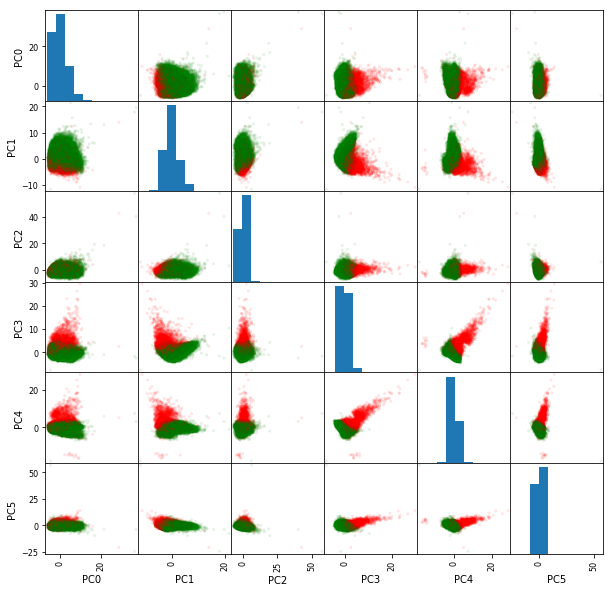

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Fixing random state for reproducibility

# plt.scatter(np.log(encode_X[0]), np.log(encode_X[1]) )# s=area, c=colors, alpha=0.5

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-1, 1)
#plt.ylim(-1, 1)

#plt.show()


%matplotlib inline
from pandas import scatter_matrix
import matplotlib.pyplot as plt

cols_ = ['PC0','PC1','PC2','PC3','PC4','PC5']
#cols_ = ['AE0','AE1','AE2','AE3','AE4','AE5']

default_colors = test_df2['default'].apply(lambda x : 'red' if x == 1 else 'green')

scatter_matrix(test_df2[cols_], alpha=0.1, figsize=[10,10], grid=True, c=default_colors)
#scatter_matrix(encode_X[cols_], alpha=0.4, figsize=[10,10], grid=True)

#marker='o',c=pcomps.Churn.apply(lambda x:churn_colors[x]

plt.show()

### Explore Some outliers ...

In [ ]:
#len(pca_encode_X[pca_encode_X['PC0']>200]) #23
pca_encode_X.shape

In [ ]:
test_df2[test_df2['PC0'] > 200].shape


In [ ]:
test_df2[test_df2['PC0'] < 200].head(10)


In [ ]:
a=test_df2[test_df2['PC0'] > 200].describe()
a

In [ ]:
b=test_df2[test_df2['PC0'] < 200].describe()
b

In [ ]:
b-a

In [ ]:
#from sklearn.cluster import KMeans
#import numpy as np
#X = ticker_encode
#num_clusters=9
#
#kmmdl = []
#km_inertia = []
#
#for i in range(1,15) :
#    kmmdl.append(KMeans(n_clusters=i, random_state=2, max_iter=1000, n_init=20).fit(ticker_encode))
#    km_inertia.append(kmmdl[i-1].inertia_)            
#
#plt.figure()
#plt.scatter(x=range(1,15),y=np.log(km_inertia))
#plt.xlabel("Clusters")
#plt.ylabel("log(SSE) (distance to centroid)")
#plt.title("Kmeans Elbow Analysis")
# 

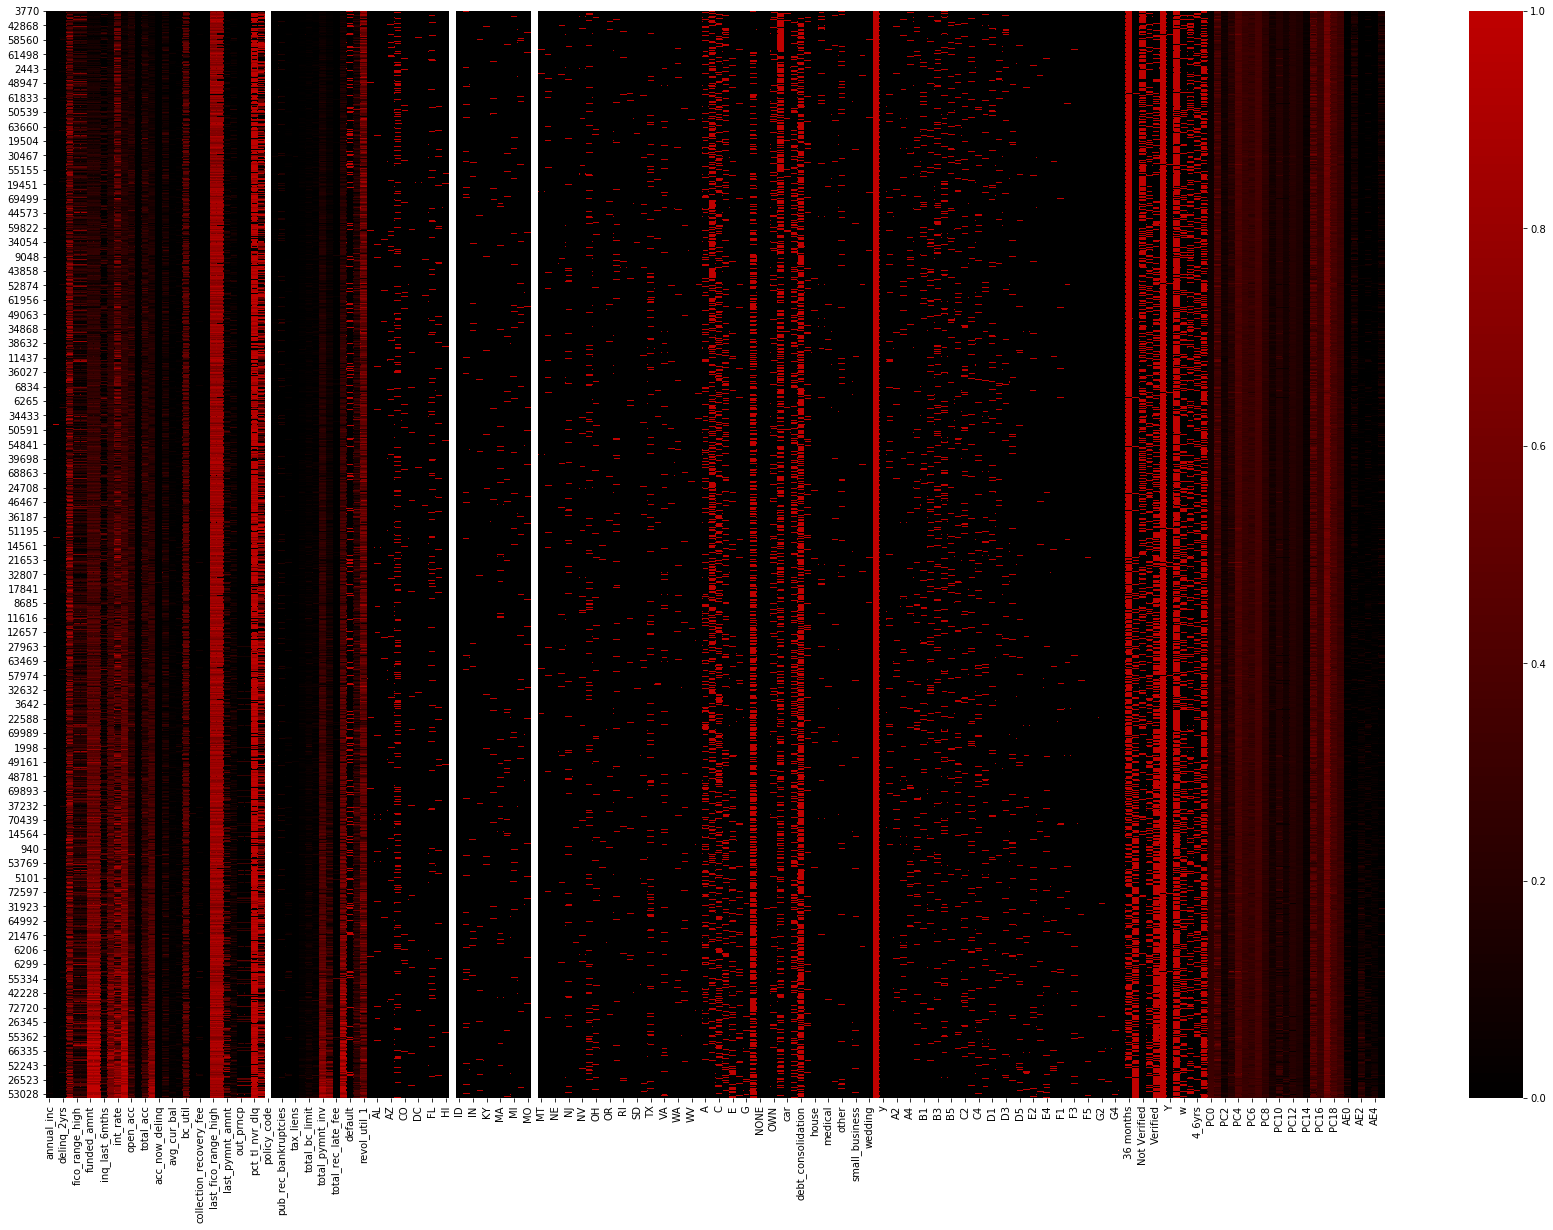

In [23]:
### Heat Map
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

def bobHeatmap(df,sortColumn):
    df = df.drop(['id','index'], axis=1)
    # scale it all on a 0-1 range ....
    df = (df - df.min(0)) / (df.max(0) -df.min(0))

    plt.figure(figsize=(30, 20))
    
    CMAP = "gist_heat"
    #CMAP = "gist_ncar"
    
    if(sortColumn not in df.columns): # check if a sort column was passed in
        ax = sns.heatmap(df, yticklabels = 1000, cmap=CMAP, center = 1)
    else:
        ax = sns.heatmap(df.sort_values(by=[sortColumn]), yticklabels = 1000, cmap=CMAP, center = 1)

#ax = sns.heatmap(df, yticklabels = 1000, cmap=CMAP, center = 1)

bobHeatmap(test_df2, 'PC0')
#test_df2.dtypes#
#plt.figure(figsize=(30, 20))
#ax = sns.heatmap(test_df2.drop(['id','index'], axis=1).sort_values(by=['PC0']), yticklabels = 100, cmap="gist_heat", center = 1)
#test_df2.drop(['id','index'], axis=1).head(2)

### Logistic Regression
** Use CrossValidator and ParamGridBuilder to search for best model **

In [24]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
# grab just my PC's and datetime info ... 
# probably combine them too ... day_hr ... that would probably be very predictive
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-5, 0, 5)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
hyperparameters

{'C': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
        1.00000000e+00]), 'penalty': ['l1', 'l2']}

### Transform train/test data via PCA / AE

In [25]:
# Fit grid search
X_pca_train = pca.transform(X_scaled)
X_ae_train = embedded_ts.predict(x=X_scaled)
X_pca_test = pca.transform(X_test_scaled)
X_ae_test = embedded_ts.predict(x=X_test_scaled)


### Train Logistic Classifer

In [47]:
from sklearn.model_selection import GridSearchCV

# Create grid search using 3-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)


print(X_t.shape)
print(Y.shape)
best_model = clf.fit(X_pca_t, Y)

(112908, 6)
(112908,)


In [43]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(Y_test, best_model.predict(pca.transform(X_test_scaled)))
confusion_matrix(Y_test, best_model.predict(embedded_ts.predict(X_test_scaled)))

#F1 = ??
# PCA ....
# array([[62507,   886],
#        [ 2497,  9383]])
#
# AE
# array([[61822,  1571],
#        [ 6429,  5451]])

# interp ???

array([[61822,  1571],
       [ 6429,  5451]])

In [40]:
Y_test.describe()

count    75273.000000
mean         0.157826
std          0.364580
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [ ]:
yes... default predicter = 85% correct... i am 95%! using simple logistic...
AE ~ 89% ... bahhh
now lets throw some DL at it

** Deep Learning Classifier **  (USE PCA Encode)

Note that the default metric for the BinaryClassificationEvaluator is areaUnderROC

In [ ]:

1. build a keras model
2. train

In [50]:
# np.sum(test_df2['default']-test_df2['logistic_pre'])
X_pca_t.shape[1]

20

In [76]:
#Compare DL vs Logistic ....
r = 0.0001

input_layer = Input(shape=(X_pca_t.shape[1], ), name="input_layer")
fc0 = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(r), name="FC0")(input_layer)      
#fc1 = Dense(5, activation= 'sigmoid', kernel_regularizer=regularizers.l2(r), name="FC1")(layer[-1]) 
output_layer = Dense(1, activation= 'sigmoid', kernel_regularizer=regularizers.l2(r), name="final_layer")(fc0) 

        
# construct and compile AE model
dl_classifier = Model(input_layer, output_layer)
dl_classifier.compile(optimizer='sgd', loss='mean_squared_error')
  

dl_classifier.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 20)                0         
_________________________________________________________________
FC0 (Dense)                  (None, 10)                210       
_________________________________________________________________
final_layer (Dense)          (None, 1)                 11        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [79]:
fit_err = dl_classifier.fit(X_pca_t, Y, shuffle=False, epochs=17, batch_size = 16,verbose=True) #, validation_data=(X_pca_t,X_CV))


Epoch 1/17
112908/112908 [==============================] - 6s 54us/step - loss: 0.0341
Epoch 2/17
112908/112908 [==============================] - 6s 52us/step - loss: 0.0339
Epoch 3/17
112908/112908 [==============================] - 6s 53us/step - loss: 0.0337
Epoch 4/17
112908/112908 [==============================] - 6s 52us/step - loss: 0.0335
Epoch 5/17
112908/112908 [==============================] - 6s 57us/step - loss: 0.0334
Epoch 6/17
112908/112908 [==============================] - 7s 66us/step - loss: 0.0332
Epoch 7/17
112908/112908 [==============================] - 5s 44us/step - loss: 0.0331
Epoch 8/17
112908/112908 [==============================] - 5s 44us/step - loss: 0.0330
Epoch 9/17
112908/112908 [==============================] - 5s 44us/step - loss: 0.0328
Epoch 10/17
112908/112908 [==============================] - 5s 42us/step - loss: 0.0327
Epoch 11/17
112908/112908 [==============================] - 5s 44us/step - loss: 0.0326
Epoch 12/17
112908/112908 [===

In [78]:

#Y_test
Y_test_predict = np.where(dl_classifier.predict(x=X_pca_test) > 0.5, 1, 0 )

confusion_matrix(Y_test, Y_test_predict)
# array([[62507,   886],
#        [ 2497,  9383]])

array([[62424,   969],
       [ 2203,  9677]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from itertools import compress
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_mat.png', bbox_inches='tight', format='png', dpi=300, pad_inches=0,transparent=True)
    plt.show()
    return

class_names =  ['Test Set No Default','Test Set Default']  
cnf_matrix = confusion_matrix(test_df2['default'], test_df2['logistic_pre'])

plot_confusion_matrix(cnf_matrix, class_names)


## Model Deployment via Watson Machine Learning Service(WML)

<img src="https://github.com/CatherineCao2016/lendingclub/raw/master/depolyment.png" width="800" height="500" align="middle"/>

**Create Pipeline for WML**

In [ ]:
# inputdf should have a non-doubt DEFAULT column

def build_model(inputdf):
    
    inputdf = inputdf.withColumn('label', inputdf['DEFAULT'].cast(DoubleType()))
    
    catCols = ['EMP_LENGTH', 'VERIFICATION_STATUS', 'HOME_OWNERSHIP', 'PURPOSE', 'ADDR_STATE', 'TERM']
    
    # to_do: is it possible use for loop to produce the following? so we could user-define variable list
    SI1 = StringIndexer(inputCol='EMP_LENGTH', outputCol='EMP_LENGTH'+"Index")
    SI2 = StringIndexer(inputCol='VERIFICATION_STATUS', outputCol='VERIFICATION_STATUS'+'Index')
    SI3 = StringIndexer(inputCol='HOME_OWNERSHIP', outputCol='HOME_OWNERSHIP'+'Index')
    SI4 = StringIndexer(inputCol='PURPOSE', outputCol='PURPOSE'+'Index')
    SI5 = StringIndexer(inputCol='ADDR_STATE', outputCol='ADDR_STATE'+'Index')
    SI6 = StringIndexer(inputCol='TERM', outputCol='TERM'+'Index')

    OH1 = OneHotEncoder(inputCol='EMP_LENGTH' + 'Index', outputCol='EMP_LENGTH' + 'classVec')
    OH2 = OneHotEncoder(inputCol='VERIFICATION_STATUS' + 'Index', outputCol='VERIFICATION_STATUS' + 'classVec')
    OH3 = OneHotEncoder(inputCol='HOME_OWNERSHIP' + 'Index', outputCol='HOME_OWNERSHIP' + 'classVec')
    OH4 = OneHotEncoder(inputCol='PURPOSE' + 'Index', outputCol='PURPOSE' + 'classVec')
    OH5 = OneHotEncoder(inputCol='ADDR_STATE' + 'Index', outputCol='ADDR_STATE' + 'classVec')
    OH6 = OneHotEncoder(inputCol='TERM' + 'Index', outputCol='TERM' + 'classVec')
    
    numCols = ['LOAN_AMNT', 'ANNUAL_INC', 'INQ_LAST_6MTHS', 'OPEN_ACC', 'PUB_REC', 'REVOL_UTIL', 'DTI', 'TOTAL_ACC', 'DELINQ_2YRS', 'EMP_LISTED', 'EMPTY_DESC', 'EMP_NA', 'DELING_EVER', 'TIME_HISTORY']
    
    assemblerInputs = map(lambda c: c + "classVec", catCols) + numCols
    
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_non_scaled")
    
    scaler = StandardScaler(withMean=False, withStd=True, inputCol="features_non_scaled", outputCol="features")
    #scalerModel = scaler.fit(loan_spark)
    #loan_spark = scalerModel.transform(loan_spark)
    
    
    
    print "Training Model..."
    
    #lr_final = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.0, threshold = 0.5, labelCol="label", featuresCol="features")
    
    rf_final_model = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth = 6, maxBins = 60, numTrees = 20)

    # Use the best model from your cross validation runs above ...
    pipeline_lr = Pipeline(stages=[SI1, SI2, SI3, SI4, SI5, SI6, OH1, OH2, OH3, OH4, OH5, OH6, assembler,scaler, lrCvModel.bestModel])
    pipeline_rf = Pipeline(stages=[SI1, SI2, SI3, SI4, SI5, SI6, OH1, OH2, OH3, OH4, OH5, OH6, assembler,scaler, rfCvModel.bestModel])
     
    model_lr = pipeline_lr.fit(inputdf)
    model_rf = pipeline_rf.fit(inputdf)

    
    print "Model built!!"
    
    return pipeline_lr, model_lr, pipeline_rf, model_rf

In [ ]:
# loan_spark as training dataset with label, cv not applicatiable
loan_spark_read = spark.read.parquet("home/lending_club/loan_sub_kp").cache()
pipeline_lr, model_lr, pipeline_rf, model_rf = build_model(loan_spark_read)

** Set up Watson Machine Learning Credentials **

In [ ]:
# 
cc_creds = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "8I7slbLraBwPGRVdAvhVBs4quUlHxQBfVh9AcsReS3CEYVe+pQs2Lmppeo/ZVIpYHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv",
  "username": "0b45b40e-f2e5-43a4-bc0a-55cb076a4ee6",
  "password": "813db8af-b707-4e59-a676-357cfe1ac299"
}


dv_creds = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "kbXV3OOJ0i2mjGVhB461icjYpZlBFyiIjIpOn/ys0bSNe4rD50whFt1EcTocKgHvHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv",
  "username": "7ddbfc51-2af5-4029-8e7f-f609a255fd5b",
  "password": "f5604e9e-7220-4f23-8a42-1ff814a72362",
  "instance_id": "d51854a2-84b2-41db-90f0-ac2419a944f2"
}
# Using Dustin's WML creds for now
creds = dv_creds

## UDFs

In [ ]:
def download(url):
    filename = url.split('/')[-1]
    print 'Downloading', filename
    http = urllib3.PoolManager()
    response = http.request('GET', url)
    data = response.data
    with open(filename, 'w') as myfile:
        myfile.write(data)

#download('https://raw.githubusercontent.com/CatherineCao2016/lendingclub/master/deployfuncs.py')

In [ ]:
%%bash
touch __init__.py
rm -rf ./wml_deployfuncs.py
wget https://github.com/dustinvanstee/lendingclub/raw/master/lendingclub-flask-demo/wml_deployfuncs.py

In [ ]:
import wml_deployfuncs

### Save the model to WML repository

In [ ]:
loan_spark_read = loan_spark_read.withColumn('label', loan_spark_read['DEFAULT'].cast(DoubleType()))
print "Saving Modeling...Model ID:"
published_model_name_or_id = save_model_by_name(creds, "lc_rf_defaultprediction", model_rf, loan_spark_read)
published_model_name_or_id = save_model_by_name(creds, "lc_lr_defaultprediction", model_lr, loan_spark_read)


### Deploy the saved model

In [ ]:
published_models_json = get_published_models(creds)
rf_scoring_url = deploy_model(creds, published_models_json, "lc_rf_defaultprediction")
lr_scoring_url = deploy_model(creds, published_models_json, "lc_lr_defaultprediction")



### Scoring: Call REST API

** Create a JSON Sample record for scoring **

In [ ]:
sample_data = {
  "fields": ['LOAN_AMNT',
 'EMP_LENGTH',
 'VERIFICATION_STATUS',
 'HOME_OWNERSHIP',
 'ANNUAL_INC',
 'PURPOSE',
 'INQ_LAST_6MTHS',
 'OPEN_ACC',
 'PUB_REC',
 'REVOL_UTIL',
 'DTI',
 'TOTAL_ACC',
 'DELINQ_2YRS',
 'EARLIEST_CR_LINE',
 'ADDR_STATE',
 'TERM',
 'DEFAULT',
 'EMP_LISTED',
 'EMPTY_DESC',
 'EMP_NA',
 'DELING_EVER',
 'TIME_HISTORY'],
  "values": [
    [4500, '< 1 year', 'Verified', 'RENT', 80000, 'major_purchase', 1, 9, 0, 18.3, 5.39, 16, 0, 780969600000000000, 'CA', '36 months', 0, 1, 0, 0, 0, 6148, 0]
  ]
}

sample_json = json.dumps(sample_data)

** Make API call for scoring **

In [ ]:
print lr_scoring_url

In [ ]:
# Get the scoring endpoint from the WML service
scoring_response = score_example(creds, lr_scoring_url, sample_json)


** Grab Prediction Value  **

In [ ]:
wml = json.loads(scoring_response)

# First zip the fields and values together
zipped_wml = zip(wml['fields'], wml['values'].pop())

# Next iterate through items and grab the prediction value
print "Default Prediction for this borrower is: " + str([v for (k,v) in zipped_wml if k == 'prediction'].pop())
print "Default Probability for this borrower is: " + str([v for (k,v) in zipped_wml if k == 'probability'].pop())

## Default Prediction App Powered by Watson Machine Learning

Go to the web app: https://lendingclub-flask-demo.mybluemix.net/#

To view the source of this web app, go here https://github.com/dustinvanstee/lendingclub

## Model Retraining and Redeploying -> [WIP]

In [ ]:
# retrain_and_deploy(creds, loan_spark_read, "Updated_LR_Model")